In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

In [8]:
import matplotlib.pyplot as plt

In [9]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

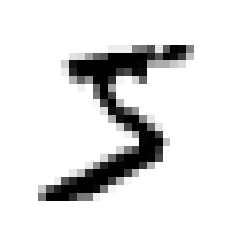

In [10]:
some_digit = X[0] 
plot_digit(some_digit)
plt.show()

In [11]:
y[0]

'5'

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier
Starting simple, we will just look for the 5s in the dataset.

In [13]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [14]:
y_train_5[:5]

array([ True, False, False, False, False])

In [15]:
from sklearn.linear_model import SGDClassifier

sgdclf = SGDClassifier(random_state=42)
sgdclf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgdclf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgdclf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.dummy import DummyClassifier

dummyclf = DummyClassifier()
dummyclf.fit(X_train, y_train_5)
print(any(dummyclf.predict(X_train)))

False


In [19]:
cross_val_score(dummyclf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgdclf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_train_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_train_fold)
    print (n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgdclf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) , recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [25]:
y_scores = cross_val_predict(sgdclf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

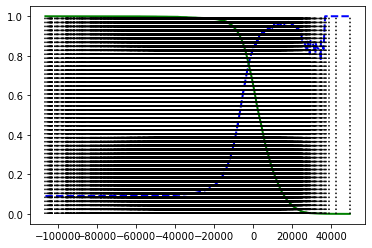

In [27]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(thresholds, 0, 1.0, "k", "dotted", label="Treshold")
plt.show()

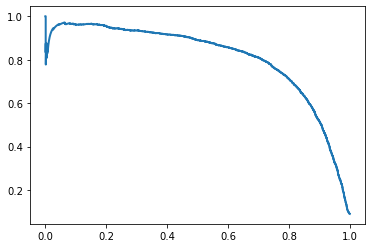

In [28]:
plt.plot(recalls, precisions, linewidth=2, label="Recall Precision Curve")
plt.show()

In [29]:
idx_for_90_precision = (precisions>0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [30]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

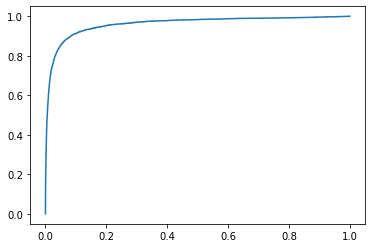

In [34]:
plt.plot(fpr, tpr)
plt.show()

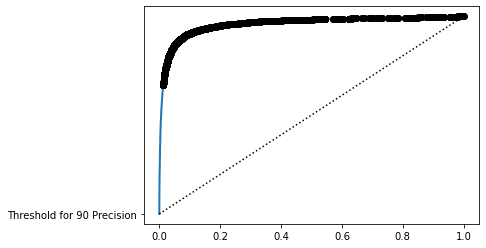

In [35]:
idx_for_threshold_at_90 = thresholds <= threshold_for_90_precision.argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0,1], [0,1], 'k:', label="Random Classifier" )
plt.plot([fpr_90], [tpr_90], 'ko', "Threshold for 90 Precision")
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [38]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [39]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest= precision_recall_curve(y_train_5, y_scores_forest)

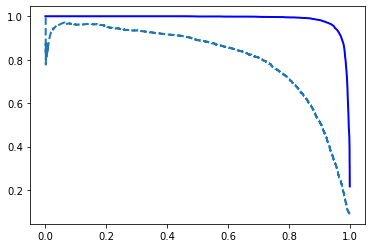

In [40]:
plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, '--', linewidth=2, label="SGD")
plt.show()

In [41]:
y_train_pred_forest = y_probas_forest[:,1] > 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9242275142688446

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

SVM does not handle multiclass problems, so sklearn will actually create many one on one classfiers, 45 in this case. Also, SVM does not scale well, (which is why sklearn does OvO intead of OvE), so we are training only on 2000 examples

In [43]:
from sklearn.svm import SVC

svm_clf = SVC(random_state = 42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [44]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The decision function is the combination of 10 one on one classifiers. The one for "5" has the highest score. It essentially gets a point for each duel it won, with a small adjustment. The other digits that scored well were 2, 3, and 8. That seems strange, I would expect 5's and 6's to be close, but if you look at the image, you can see that it looks nothing like a 6.

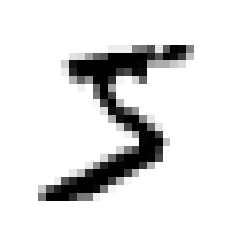

In [46]:
plot_digit(some_digit)
plt.show()

In [47]:
class_id = some_digit_scores.argmax()

In [48]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [49]:
svm_clf.classes_[class_id]

'5'

In [50]:
# Your can specify OvO or OvE with any algorithm. (Even non-binary ones)
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [51]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [52]:
len(ovr_clf.estimators_)

10

In [53]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [54]:
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [55]:
# Wait, that's not right. R2 you are playing the wrong message
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [56]:
# because this is balanced dataset, accuracy is fine as a metric
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

## Error Analysis

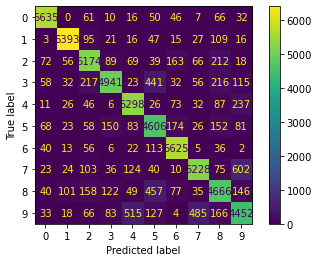

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

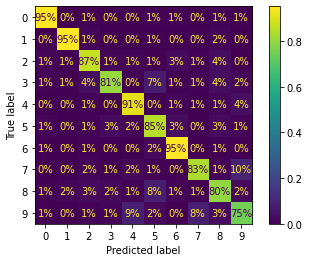

In [58]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

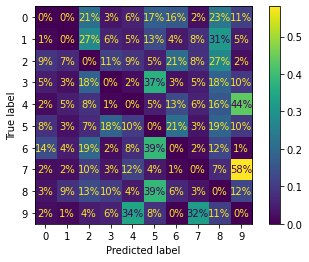

In [59]:
# Can show just the errors
sample_weight = (y_train != y_train_pred)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        sample_weight=sample_weight, normalize="true", 
                                        values_format=".0%")
plt.show()

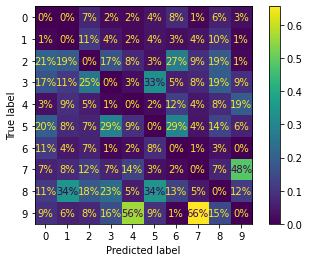

In [60]:
# Can also normalize by column
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight,
                                       normalize="pred", values_format=".0%")

Comparing the two normalized charts, we can see from the first that when we mislabled a 9, 32% of the time we thought it was a 7. In the second we can see that 66% of the time we made an error when we predicted a 7, it was a 9.

From the 2 charts we can see that a lot of the errors we made were incorrectly predicting 8s, so we may want to add more images to our training set that look like 8s, but aren't. The book suggests that you could add a new feature that counts the number of closed loops. Seems like that would be a training job of its own. Or you could do image processing to make the loops stand out more.

You could also plot examples of images that were classified correctly and incorrectly to see the mistakes it is making.

In [61]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_pred == cl_b)]

/var/folders/c1/2ltzp02n15z_6jjqlpm151gc0000gn/T/ipykernel_9436/1219606890.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_aa = X_train[(y_train == cl_a) & (y_pred == cl_a)]
/var/folders/c1/2ltzp02n15z_6jjqlpm151gc0000gn/T/ipykernel_9436/1219606890.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_ab = X_train[(y_train == cl_a) & (y_pred == cl_b)]


## Multilabel Classification

In [64]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [65]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [67]:
# One way to evaluate multi-label classifier is to average F1 score for each label
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [68]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [69]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification

In [71]:
# Create a dataset with noise in it, and use the unmodified as the test set
np.random.seed(42)

noise = np.random.randint(0, 100, (len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

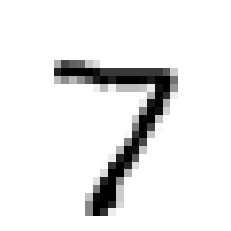

In [75]:
plot_digit(y_test_mod[0])
plt.show()

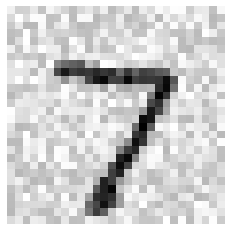

In [76]:
plot_digit(X_test_mod[0])
plt.show()

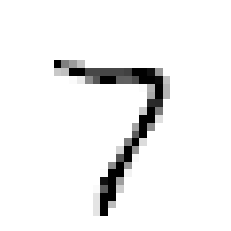

In [77]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()